In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math 
import tensorflow as tf
import operator
import matplotlib.pyplot as plt
from tensorflow import keras
import keras
import timeit
from tqdm import tqdm
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold



In [2]:
from google.colab import files
files= files.upload()

Saving in-vehicle-coupon-recommendation.csv to in-vehicle-coupon-recommendation.csv


In [3]:
df= pd.read_csv("in-vehicle-coupon-recommendation.csv")
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


# Explanatory Data Analysis 



*   Data Cleaning
*   Statistical Analysis
*   Feature Transformation 
*   Data Encoding
*   Feature Selection






Data Cleaning:

In [4]:
#drop dupilicate data
df = df.drop_duplicates()

In [5]:
# check missing value
df.isnull().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12502
Bar                       107
CoffeeHouse               217
CarryAway                 150
RestaurantLessThan20      129
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

In [6]:
# fill na with mode
df = df.drop(columns=['car'])
df['Bar'].fillna(df['Bar'].mode()[0], inplace=True)
df['CoffeeHouse'].fillna(df['CoffeeHouse'].mode()[0], inplace=True)
df['CarryAway'].fillna(df['CarryAway'].mode()[0], inplace=True)
df['RestaurantLessThan20'].fillna(df['RestaurantLessThan20'].mode()[0], inplace=True)
df['Restaurant20To50'].fillna(df['Restaurant20To50'].mode()[0], inplace=True)

In [7]:
df.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12610 entries, 0 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12610 non-null  object
 1   passanger             12610 non-null  object
 2   weather               12610 non-null  object
 3   temperature           12610 non-null  int64 
 4   time                  12610 non-null  object
 5   coupon                12610 non-null  object
 6   expiration            12610 non-null  object
 7   gender                12610 non-null  object
 8   age                   12610 non-null  object
 9   maritalStatus         12610 non-null  object
 10  has_children          12610 non-null  int64 
 11  education             12610 non-null  object
 12  occupation            12610 non-null  object
 13  income                12610 non-null  object
 14  Bar                   12610 non-null  object
 15  CoffeeHouse           12610 non-null

In [9]:
df.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12610.000000,12610.000000,12610.0,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000
mean,63.267248,0.414512,1.0,0.559794,0.116019,0.215543,0.784457,0.567565
std,19.153386,0.492657,0.0,0.496432,0.320260,0.411215,0.411215,0.495434
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


Statistical Analysis

Accepted coupon: 7157 56.76 %
Rejected coupon: 5453 43.24 %


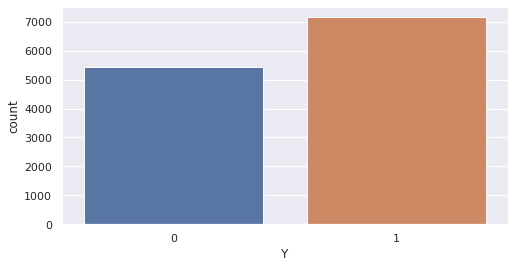

In [10]:
# Distribution of classes
sns.set(rc={"figure.figsize":(8,4)})
sns.countplot(x='Y', data=df)
Y_counts = df.groupby('Y').Y.count()
print('Accepted coupon:',Y_counts[1],round(Y_counts[1]/df.shape[0]*100,2),'%')
print('Rejected coupon:',Y_counts[0],round(Y_counts[0]/df.shape[0]*100,2),'%')

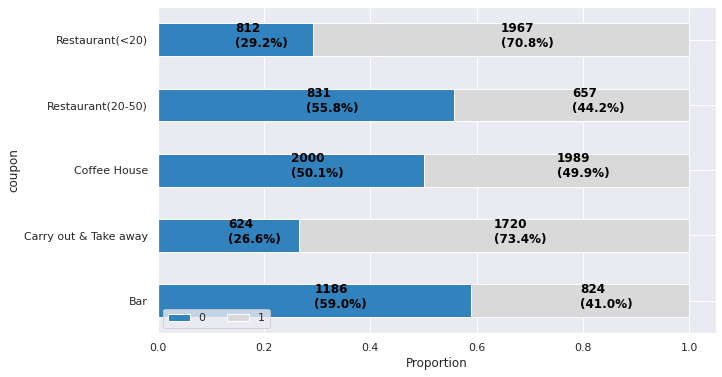

In [11]:
# univariate (coupon & Y)
df_coupon = df[['coupon','Y']]
cross_tab = pd.crosstab(index=df_coupon['coupon'],
                        columns=df_coupon['Y'])
cross_tab_prop = pd.crosstab(index=df_coupon['coupon'],
                             columns=df_coupon['Y'],
                             normalize="index")
cross_tab_prop.plot(kind='barh', 
                        stacked=True, 
                        colormap='tab20c', 
                        figsize=(10, 6))

plt.legend(loc="lower left", ncol=2)
plt.ylabel("coupon")
plt.xlabel("Proportion")


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.show()

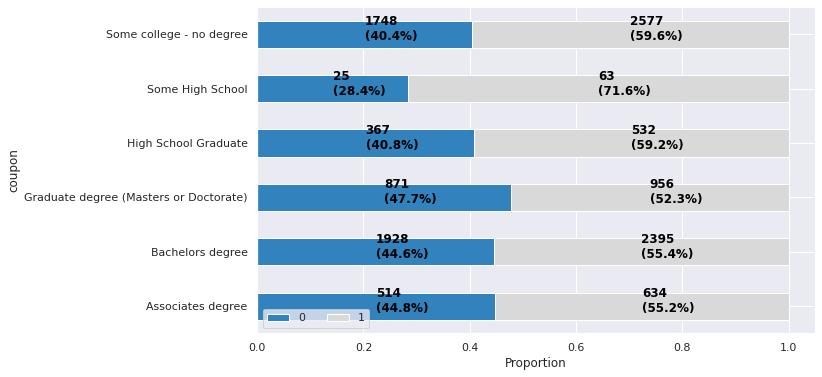

In [12]:
# Univeriate(education & Y)
df_edu = df[['education','Y']]
cross_tab = pd.crosstab(index=df_edu['education'],
                        columns=df_edu['Y'])
cross_tab_prop = pd.crosstab(index=df_edu['education'],
                             columns=df_edu['Y'],
                             normalize="index")
cross_tab_prop.plot(kind='barh', 
                        stacked=True, 
                        colormap='tab20c', 
                        figsize=(10, 6))

plt.legend(loc="lower left", ncol=2)
plt.ylabel("coupon")
plt.xlabel("Proportion")


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.show()

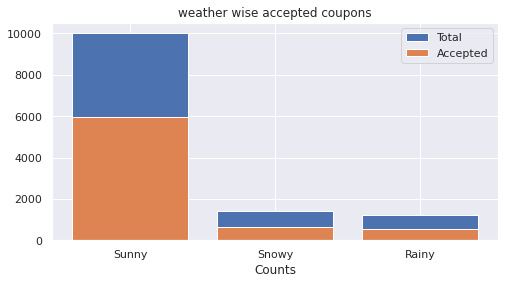

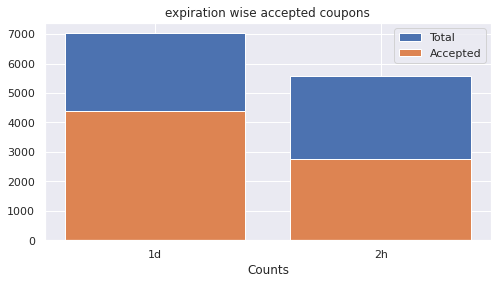

In [13]:
def univariate_analysis(column_name):
    df_EDA = pd.DataFrame(sorted(list(df[column_name].unique())),columns=[column_name])
    df_EDA['Total_Count'] = list(df.groupby(column_name).Y.count())
    df_EDA['Accepted'] = list(df[df.Y==1].groupby(column_name).Y.count())
    df_EDA['Rejected'] = list(df[df.Y==0].groupby(column_name).Y.count())
    df_EDA['%Accepted'] = round(df_EDA['Accepted']/df_EDA['Total_Count']*100,3)
    df_EDA['%Rejected'] = round(df_EDA['Rejected']/df_EDA['Total_Count']*100,3)
    df_EDA = df_EDA.sort_values(by='Total_Count', ascending=False)
    
    fig,ax = plt.subplots(figsize =(8, 4))
    plt.bar(df_EDA[column_name],df_EDA['Total_Count'])
    plt.bar(df_EDA[column_name],df_EDA['Accepted'])
    plt.legend(labels=['Total','Accepted'])
    plt.xlabel('Counts')
    plt.title(column_name+' wise accepted coupons')

univariate_analysis('weather')
univariate_analysis('expiration')

In [14]:
#Bivariate Analysis(time & coupon & Y)
df_time_coupon = df[["time","coupon","Y"]]

df_reje = df_time_coupon.loc[df_time_coupon['Y'] == 0]
df_acce = df_time_coupon.loc[df_time_coupon['Y'] == 1]


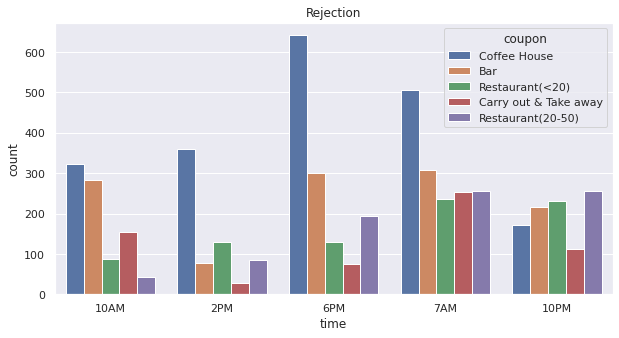

In [15]:
sns.set(rc={"figure.figsize":(10,5)})
sns.countplot(data=df_reje, x='time', hue='coupon' ).set(title='Rejection')
plt.show()

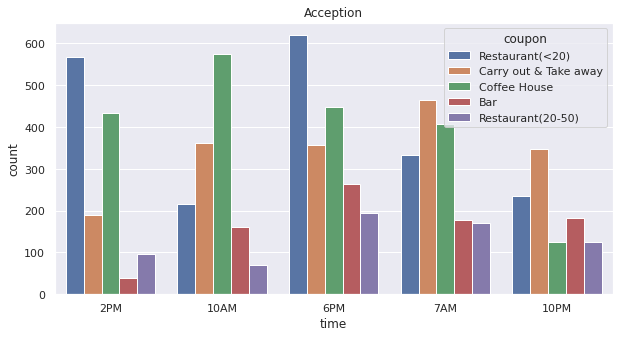

In [16]:
sns.set(rc={"figure.figsize":(10,5)})
sns.countplot(data=df_acce, x='time', hue='coupon').set(title='Acception')
plt.show()

Feature Transformation:

In [17]:
# combine "toCoupon_GEQ5min","toCoupon_GEQ15min" and "toCoupon_GEQ25min" into one column
def custom_where(ele):
  x,y,z = list(map(str,ele))
  if x == '1':
    if y == '1':
      if z == '1':
        return 'within 25mins'
      else:
        return 'within 15mins'
    else: return 'within 5mins'

In [18]:
df['driving_distance'] = df[['toCoupon_GEQ5min','toCoupon_GEQ15min','toCoupon_GEQ25min']].apply(custom_where,axis=1,raw=True)
df.drop(['toCoupon_GEQ5min','toCoupon_GEQ15min','toCoupon_GEQ25min'],axis=1,inplace=True)

In [19]:
#categorize it to be more simple
age_list = []
for i in df['age']:
    if i == 'below21':
        age = '<21'
    elif i == '21' or i == '26':
        age = '21-30'
    elif i == '31' or i == '36':
        age = '31-40'
    elif i == '41' or i == '46':
        age = '41-50'
    else:
        age = '>50'
    age_list.append(age)
df['age'] = age_list

In [20]:
df['age'].unique()

array(['21-30', '41-50', '31-40', '>50', '<21'], dtype=object)

In [21]:
#categorize it to be more simple
occupation_list = []
for i in df['occupation']:
    if i == 'Installation Maintenance & Repair' or i == 'Transportation & Material Moving' or i == 'Food Preparation & Serving Related' or i == 'Building & Grounds Cleaning & Maintenance':
        occupation = 'Crafts'
    elif i == 'Architecture & Engineering' or i == 'Education&Training&Library' or i == 'Healthcare Practitioners & Technical' or i == 'Management' or i == 'Arts Design Entertainment Sports & Media' or i == 'Computer & Mathematical' or i == 'Legal' or i == 'Business & Financial':
        occupation = 'Professionals'
    elif i == 'Retired':
        occupation = 'Retired'
    elif i == 'Sales & Related' or i == 'Personal Care & Service' or i == 'Protective Service':
        occupation = 'Service and sales'
    elif i == 'Student':
        occupation = 'Student'
    elif i == 'Healthcare Support' or i == 'Life Physical Social Science' or i == 'Community & Social Services' or i == 'Construction & Extraction':
        occupation = 'Technicians'
    elif i == 'Unemployed':
        occupation = 'Unemployed'
    else:
        occupation = 'Others'
    occupation_list.append(occupation)
df['occupation'] = occupation_list

In [22]:
df['occupation'].unique()

array(['Unemployed', 'Professionals', 'Student', 'Technicians',
       'Service and sales', 'Others', 'Retired', 'Crafts'], dtype=object)

In [23]:
has_children_list = []
for i in df['has_children']:
    if i == 1:
        has_children = 'Yes'
    else:
      has_children = 'No'
    has_children_list.append(has_children)
df['has_children'] = has_children_list

In [24]:
df['has_children'].unique()

array(['Yes', 'No'], dtype=object)

In [25]:
temperature_list = []
for i in df['temperature']:
    if i == 30:
      temperature = 'Low'
    elif i==55:
      temperature= 'Medium'
    else:
      temperature = 'High'
    temperature_list.append(temperature)
df['temperature'] = temperature_list 

In [26]:
direction_same_list = []
for i in df['direction_same']:
    if i == 1:
      direction_same = 'Yes'
    else:
      direction_same = 'No'
    direction_same_list.append(direction_same)
df['direction_same'] = direction_same_list

In [27]:
Y_list = []
for i in df['Y']:
    if i == 1:
      Y = 'Accept'
    else:
      Y = 'Reject'
    Y_list.append(Y)
df['Y'] = Y_list

In [28]:
df['Y'].unique()

array(['Accept', 'Reject'], dtype=object)

Data Encoding

In [29]:
df_enco = df.copy()
label_encoder = preprocessing.LabelEncoder()
df_enco['passanger']= label_encoder.fit_transform(df_enco['passanger'])
df_enco['weather']= label_encoder.fit_transform(df_enco['weather'])
df_enco['time']= label_encoder.fit_transform(df_enco['time'])
df_enco['coupon']= label_encoder.fit_transform(df_enco['coupon'])
df_enco['expiration']= label_encoder.fit_transform(df_enco['expiration'])
df_enco['gender']= label_encoder.fit_transform(df_enco['gender'])
df_enco['age']= label_encoder.fit_transform(df_enco['age'])
df_enco['maritalStatus']= label_encoder.fit_transform(df_enco['maritalStatus'])
df_enco['education']= label_encoder.fit_transform(df_enco['education'])
df_enco['occupation']= label_encoder.fit_transform(df_enco['occupation'])
df_enco['income']= label_encoder.fit_transform(df_enco['income'])
df_enco['Bar']= label_encoder.fit_transform(df_enco['Bar'])
df_enco['CoffeeHouse']= label_encoder.fit_transform(df_enco['CoffeeHouse'])
df_enco['CarryAway']= label_encoder.fit_transform(df_enco['CarryAway'])
df_enco['RestaurantLessThan20']= label_encoder.fit_transform(df_enco['RestaurantLessThan20'])
df_enco['Restaurant20To50']= label_encoder.fit_transform(df_enco['Restaurant20To50'])
df_enco['driving_distance']= label_encoder.fit_transform(df_enco['driving_distance'])
df_enco['temperature']= label_encoder.fit_transform(df_enco['temperature'])
df_enco['has_children']= label_encoder.fit_transform(df_enco['has_children'])
df_enco['direction_same']= label_encoder.fit_transform(df_enco['direction_same'])
df_enco['destination']= label_encoder.fit_transform(df_enco['destination'])
df_enco['Y']= label_encoder.fit_transform(df_enco['Y'])

Feature Selection

(array([8.51872185e-02, 4.49153726e+01, 2.80958257e+01, 4.15522212e+01,
       2.79059310e+01, 1.09915816e+02, 1.16527040e+02, 1.23766588e+01,
       4.06618193e+01, 3.27933140e+00, 1.49879269e+01, 3.22563112e+01,
       2.95063861e-01, 1.39837347e+01, 6.71770851e+01, 2.97944201e+02,
       3.40513002e+01, 2.24323428e+00, 3.98201425e+01, 2.20550210e+00,
       6.06000274e-01, 2.85147148e+01]), array([7.70387172e-01, 2.05736369e-11, 1.15454615e-07, 1.14764019e-10,
       1.27358779e-07, 1.02241869e-25, 3.64377189e-27, 4.34734409e-04,
       1.80989197e-10, 7.01575045e-02, 1.08201215e-04, 1.35117495e-08,
       5.86993614e-01, 1.84398961e-04, 2.48182102e-16, 9.23986896e-67,
       5.36780295e-09, 1.34200019e-01, 2.78458532e-10, 1.37519112e-01,
       4.36297765e-01, 9.29890840e-08]))


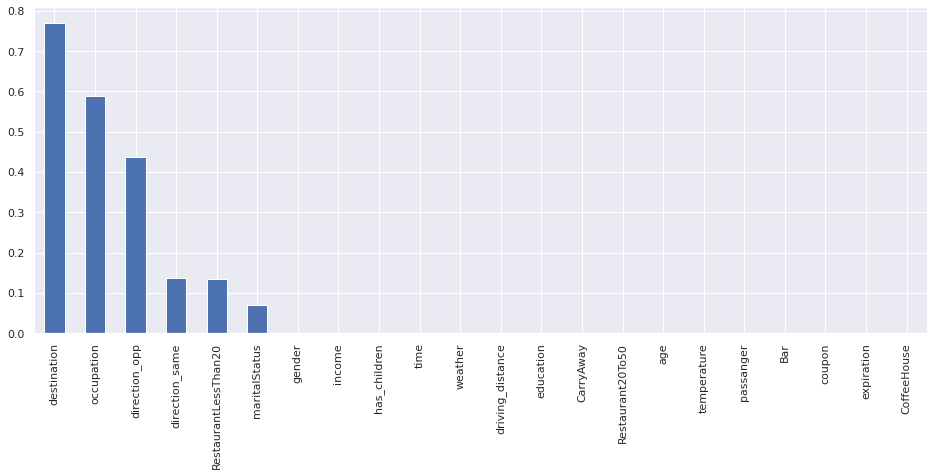

In [30]:
X = df_enco.drop('Y',axis=1)
y = df_enco['Y']
chi_scores = chi2(X,y)
print(chi_scores)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
plt.figure(figsize=(16,6))
p_values.plot.bar()

In [31]:
df_enco = df_enco.drop(columns=['destination'])
df_enco=df_enco.drop(columns=['direction_opp'])

In [32]:
df_enco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12610 entries, 0 to 12683
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   passanger             12610 non-null  int64
 1   weather               12610 non-null  int64
 2   temperature           12610 non-null  int64
 3   time                  12610 non-null  int64
 4   coupon                12610 non-null  int64
 5   expiration            12610 non-null  int64
 6   gender                12610 non-null  int64
 7   age                   12610 non-null  int64
 8   maritalStatus         12610 non-null  int64
 9   has_children          12610 non-null  int64
 10  education             12610 non-null  int64
 11  occupation            12610 non-null  int64
 12  income                12610 non-null  int64
 13  Bar                   12610 non-null  int64
 14  CoffeeHouse           12610 non-null  int64
 15  CarryAway             12610 non-null  int64
 16  Rest

In [33]:
df = df.drop(columns=['destination'])
df = df.drop(columns=['direction_opp'])
 #drop direction_opp(highly correlated with direction_same)

# ML Algorithm


*   Naive Bayes 
*   Decision Tree 
*   Nerual Network



Naive Bayes 

In [34]:
df_NB = df.copy()

In [35]:
X_NB=df_NB.drop('Y',axis=1)
y_NB=df_NB['Y']

In [36]:
def accuracy_score(y_true, y_pred):

	"""	score = (y_true - y_pred) / len(y_true) """

	return round(float(sum(y_pred == y_true))/float(len(y_true)) * 100 ,2)



class  NaiveBayes:

	"""
		Bayes Theorem:
										Likelihood * Class prior probability
				Posterior Probability = -------------------------------------
											Predictor prior probability
				
							  			 P(x|c) * p(c)
							   P(c|x) = ------------------ 
											  P(x)
	"""

	def __init__(self):

		"""
			Attributes:
				likelihoods: Likelihood of each feature per class
				class_priors: Prior probabilities of classes 
				pred_priors: Prior probabilities of features 
				features: All features of dataset
		"""
		self.features = list
		self.likelihoods = {}
		self.class_priors = {}
		self.pred_priors = {}

		self.X_train = np.array
		self.y_train = np.array
		self.train_size = int
		self.num_feats = int

	def fit(self, X, y):

		self.features = list(X.columns)
		self.X_train = X
		self.y_train = y
		self.train_size = X.shape[0]
		self.num_feats = X.shape[1]

		for feature in self.features:
			self.likelihoods[feature] = {}
			self.pred_priors[feature] = {}

			for feat_val in np.unique(self.X_train[feature]):
				self.pred_priors[feature].update({feat_val: 0})

				for outcome in np.unique(self.y_train):
					self.likelihoods[feature].update({feat_val+'_'+outcome:0})
					self.class_priors.update({outcome: 0})


		self._calc_class_prior()
		self._calc_likelihoods()
		self._calc_predictor_prior()

		# print(self.likelihoods)
		# print(self.class_priors)
		# print(self.pred_priors)

	def _calc_class_prior(self):

		""" P(c) - Prior Class Probability """

		for outcome in np.unique(self.y_train):
			outcome_count = sum(self.y_train == outcome)
			self.class_priors[outcome] = outcome_count / self.train_size

	def _calc_likelihoods(self):

		""" P(x|c) - Likelihood """

		for feature in self.features:

			for outcome in np.unique(self.y_train):
				outcome_count = sum(self.y_train == outcome)
				feat_likelihood = self.X_train[feature][self.y_train[self.y_train == outcome].index.values.tolist()].value_counts().to_dict()

				for feat_val, count in feat_likelihood.items():
					self.likelihoods[feature][feat_val + '_' + outcome] = count/outcome_count


	def _calc_predictor_prior(self):

		""" P(x) - Evidence """

		for feature in self.features:
			feat_vals = self.X_train[feature].value_counts().to_dict()

			for feat_val, count in feat_vals.items():
				self.pred_priors[feature][feat_val] = count/self.train_size


	def predict(self, X):

		""" Calculates Posterior probability P(c|x) """

		results = []
		X = np.array(X)

		for query in X:
			probs_outcome = {}
			for outcome in np.unique(self.y_train):
				prior = self.class_priors[outcome]
				likelihood = 1
				evidence = 1

				for feat, feat_val in zip(self.features, query):
					likelihood *= self.likelihoods[feat][feat_val + '_' + outcome]
					evidence *= self.pred_priors[feat][feat_val]

				posterior = (likelihood * prior) / (evidence)

				probs_outcome[outcome] = posterior

			result = max(probs_outcome, key = lambda x: probs_outcome[x])
			results.append(result)

		return np.array(results)


In [37]:
X_NB_train, X_NB_test, y_NB_train, y_NB_test = train_test_split(X_NB , y_NB,
                                                                shuffle = True,
                                                                test_size=0.25, 
                                                                random_state=1)

print('X_train:', X_NB_train.shape)
print('X_test:', X_NB_test.shape)

X_train: (9457, 20)
X_test: (3153, 20)


In [38]:
import timeit

start = timeit.default_timer()

In [39]:
nb_clf = NaiveBayes()
nb_clf.fit(X_NB_train, y_NB_train)


In [40]:
stop = timeit.default_timer()

print('Time: ', stop - start)  

Time:  0.8714426280000112


In [41]:
print("Train Accuracy: {}".format(accuracy_score(y_NB_train, nb_clf.predict(X_NB_train))))
print("Test Accuracy: {}".format(accuracy_score(y_NB_test, nb_clf.predict(X_NB_test))))

Train Accuracy: 66.98
Test Accuracy: 66.57


In [42]:
y_NB_pred=nb_clf.predict(X_NB_test)
confusion = confusion_matrix(y_NB_test, y_NB_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[1355  447]
 [ 607  744]]


In [43]:
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_NB_test, y_NB_pred)))
print('Precision : {:.2f}'.format(precision_score(y_NB_test, y_NB_pred, pos_label='Accept', average='binary')))
print('Recal : {:.2f}'.format(recall_score(y_NB_test, y_NB_pred, pos_label='Accept', average='binary')))
print('F1 Score : {:.2f}'.format(f1_score(y_NB_test, y_NB_pred, pos_label='Accept', average='binary')))



Accuracy: 66.57
Precision : 0.69
Recal : 0.75
F1 Score : 0.72


In [44]:
print('\nNaive Bayes Classification Report\n')
print(classification_report(y_NB_test, y_NB_pred))


Naive Bayes Classification Report

              precision    recall  f1-score   support

      Accept       0.69      0.75      0.72      1802
      Reject       0.62      0.55      0.59      1351

    accuracy                           0.67      3153
   macro avg       0.66      0.65      0.65      3153
weighted avg       0.66      0.67      0.66      3153



Decision Tree 

In [45]:
df_DT = df_enco.copy()

In [46]:
X_DT = df_DT.drop('Y',axis=1)
y_DT = df_DT['Y']

In [47]:
eps = np.finfo(float).eps

def accuracy_score(y_true, y_pred):

	"""	score = (y_true - y_pred) / len(y_true) """

	return round(float(sum(y_pred == y_true))/float(len(y_true)) * 100 ,2)


class DecisionTreeClassifier:

	def __init__(self, max_depth = None, min_sample_leaf = None):

		self.depth = 0 #Depth of the tree
		self.max_depth = max_depth	#Maximum depth of the tree
		self.min_sample_leaf = min_sample_leaf	#Minimum number of samples for each node

		self.features = list
		self.X_train = np.array
		self.y_train = np.array
		self.num_feats = int 
		self.train_size = int 

	def fit(self, X, y):

		self.X_train = X 
		self.y_train = y
		self.features = list(X.columns)
		self.train_size = X.shape[0]
		self.num_feats = X.shape[1]

		df = X.copy()
		df['target'] = y.copy()

		#Builds Decision Tree
		self.tree = self._build_tree(df)

		print("\nDecision Tree(depth = {}) : \n {}".format(self.depth, self.tree))

	def _build_tree(self, df, tree = None):

		"""
			Args:
				df: current number of rows available for splitting(decision making)
		"""

		#Get feature with maximum information gain
		feature, cutoff = self._find_best_split(df)

		#Initialization of tree
		if tree is None:
			tree = {}
			tree[feature] = {}

		if df[feature].dtypes == object:
			"""
				- to handle columns with Categorical Values(object type)
 				- parent have only one child
			"""
			for feat_val in np.unique(df[feature]):

				new_df = self._split_rows(df, feature, feat_val, operator.eq)
				targets, count = np.unique(new_df['target'], return_counts = True)

				if(len(count) == 1): #pure group 
					tree[feature][feat_val] = targets[0]
				else:
					self.depth += 1
					if self.max_depth is not None and self.depth >= self.max_depth:
						tree[feature][feat_val] = targets[np.argmax(count)]
					else:
						tree[feature][feat_val] = self._build_tree(new_df)
					
		else:
			"""
				- to handle columns with Numerical Values(int, float....)
 				- parent have two child
 				- Left Child: rows with <= cutoff
 				- Right Child:  rows with > cutoff
			"""
			#Left Child
			new_df = self._split_rows(df, feature, cutoff, operator.le)
			targets, count = np.unique(new_df['target'], return_counts = True)

			self.depth += 1

			if(len(count) == 1): #pure group
				tree[feature]['<=' + str(cutoff)] = targets[0]
			else:
				if self.max_depth is not None and self.depth >= self.max_depth:
					tree[feature]['<=' + str(cutoff)] = targets[np.argmax(count)]
				else:
					tree[feature]['<=' + str(cutoff)] = self._build_tree(new_df)


			#Right Child
			new_df = self._split_rows(df, feature, cutoff, operator.gt)
			targets, count = np.unique(new_df['target'], return_counts = True)

			if(len(count) == 1): #pure group
				tree[feature]['>' + str(cutoff)] = targets[0]
			else:
				if self.max_depth is not None and self.depth >= self.max_depth:
					tree[feature]['>' + str(cutoff)] = targets[np.argmax(count)]
				else:
					tree[feature]['>' + str(cutoff)] = self._build_tree(new_df)

		return tree


	def _split_rows(self, df, feature, feat_val, operation ):

		""" split rows based on given criterion """

		return df[operation(df[feature], feat_val)].reset_index(drop = True)

	def _find_best_split(self, df):

		"""
			Finds the column to split on first using 'Information Gain' Metric.
			Information Gain(IG) = Entropy(parent) - Sum of Entropy(Children)
						IG(T, a) = H(T) - H(T|a)
			Entropy(parent) H(T) = (Sum[i=1 to J](- Pi * log(Pi)))
			Sum of Entropy(children) H(T|a) = Sum(P(a) * Sum[i=1 to J](- P(i|a) * log(P(i|a)))
			Returns:
				Feature With Maximum Information Gain
		"""

		ig = []
		thresholds = []

		for feature in list(df.columns[:-1]):

			entropy_parent = self._get_entropy(df) #H(T)
			entropy_feature_split, threshold = self._get_entropy_feature(df, feature) #H(T|a)

			info_gain = entropy_parent - entropy_feature_split #IG(T, a)

			ig.append(info_gain)
			thresholds.append(threshold)

		
		return df.columns[:-1][np.argmax(ig)], thresholds[np.argmax(ig)] #Returns feature with max information gain 

	def _get_entropy(self, df):

		""" Finds Entropy of parent ie., H(T) """

		entropy = 0
		for target in np.unique(df['target']):
			fraction = df['target'].value_counts()[target] / len(df['target'])
			entropy += -fraction * np.log2(fraction)

		return entropy

	def _get_entropy_feature(self, df, feature):

		""" Finds Sum of entropy of children ie., H(T|a) """

		entropy = 0
		threshold = None

		if(df[feature].dtypes == object):

			#sum of entropies of children(all distinct features)
			for feat_val in np.unique(df[feature]):
				entropy_feature = 0

				#entropy for each distinct feature value
				for target in np.unique(df['target']):
					num = len(df[feature][df[feature] == feat_val][df['target'] == target])
					den = len(df[feature][df[feature] == feat_val])

					fraction = num / (den+eps)
					entropy_feature += -fraction * np.log2(fraction + eps)

				weightage = den/len(df)
				entropy += weightage * entropy_feature
		else:
			entropy = 1 #Max Value

			prev = 0
			for feat_val in np.unique(df[feature]):
				cur_entropy = 0
				cutoff = (feat_val + prev)/2

				#sum of entropies of left child(<= cutoff) and right child(> cutoff)
				for operation in [operator.le, operator.gt]:
					entropy_feature = 0

					for target in np.unique(df['target']):
						num = len(df[feature][operation(df[feature], cutoff)][df['target'] == target])
						den = len(df[feature][operation(df[feature], cutoff)])

						fraction = num / (den + eps)
						entropy_feature += -fraction * np.log2(fraction + eps)

					weightage = den/len(df)
					cur_entropy += weightage * entropy_feature

				if cur_entropy < entropy:
					entropy = cur_entropy
					threshold = cutoff
				prev = feat_val

		return entropy, threshold

	def _predict_target(self, feature_lookup, x, tree):

		for node in tree.keys():
			val = x[node]
			if type(val) == str:
				tree = tree[node][val]
			else:
				cutoff = str(list(tree[node].keys())[0]).split('<=')[1]

				if(val <= float(cutoff)):	#Left Child
					tree = tree[node]['<='+cutoff]
				else:						#Right Child
					tree = tree[node]['>'+cutoff]

			prediction = str

			if type(tree) is dict:
				prediction = self._predict_target(feature_lookup, x, tree)
			else:
				predicton = tree 
				return predicton

		return prediction   


	def predict(self, X):

		results = []
		feature_lookup = {key: i for i, key in enumerate(list(X.columns))}
		
		for index in range(len(X)):

			results.append(self._predict_target(feature_lookup, X.iloc[index], self.tree))

		return np.array(results)

In [48]:
# 12610 learning curve: 0.9 training size = 1261, 0.8 r=2522, 0.7 r=3783, 0.6 r=5044, 0.5 r=6305, 0.4r=7566 ,0.3 r=8827, 0.2 r=10088

X_DT_train, X_DT_test, y_DT_train, y_DT_test = train_test_split(X_DT, y_DT, test_size = 0.25, random_state = 0)

In [49]:
X_DT_train.head()

,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,direction_same,driving_distance
5089,0,2,2,3,3,1,1,0,2,0,3,7,2,3,0,1,0,3,0,0
8484,0,2,0,0,2,0,0,4,2,0,2,2,3,3,2,0,0,0,0,2
9813,1,2,0,1,2,0,0,0,2,0,0,4,2,1,0,1,0,3,0,0
7209,0,1,1,3,2,0,0,4,1,1,5,2,3,4,0,4,0,3,0,0
11517,0,1,1,4,0,0,0,3,2,0,1,5,1,2,0,3,1,2,0,1


In [50]:
import timeit

start = timeit.default_timer()



In [51]:
dt = DecisionTreeClassifier(max_depth = 90)
dt.fit(X_DT_train, y_DT_train)



Decision Tree(depth = 90) : 
 {'coupon': {'<=3.5': {'CoffeeHouse': {'<=2.5': {'coupon': {'<=0.0': {'Bar': {'<=3.5': {'Bar': {'<=1.5': {'CarryAway': {'<=2.5': {'weather': {'<=1.5': {'occupation': {'<=5.5': {'maritalStatus': {'<=2.5': {'time': {'<=0.0': {'income': {'<=2.5': 1, '>2.5': 0}}, '>0.0': {'CarryAway': {'<=1.5': {'passanger': {'<=2.5': {'occupation': {'<=4.5': {'passanger': {'<=1.5': {'occupation': {'<=3.0': {'RestaurantLessThan20': {'<=1.5': {'income': {'<=4.5': {'CoffeeHouse': {'<=0.0': {'age': {'<=0.0': {'time': {'<=3.5': {'weather': {'<=0.0': 0, '>0.0': {'gender': {'<=0.0': 1, '>0.0': 0}}}}, '>3.5': {'gender': {'<=0.0': 0, '>0.0': 1}}}}, '>0.0': 1}}, '>0.0': 0}}, '>4.5': {'has_children': {'<=0.0': 1, '>0.0': 0}}}}, '>1.5': 0}}, '>3.0': 0}}, '>1.5': {'RestaurantLessThan20': {'<=0.0': 1, '>0.0': {'weather': {'<=0.0': {'gender': {'<=0.0': 1, '>0.0': 0}}, '>0.0': 0}}}}}}, '>4.5': {'passanger': {'<=1.5': {'weather': {'<=0.0': {'time': {'<=3.5': {'passanger': {'<=0.0': 0, '>0.0':

In [52]:
stop = timeit.default_timer()

print('Time: ', stop - start)  

Time:  18.243829833999996


In [53]:
print("Train Accuracy: {}".format(accuracy_score(y_DT_train, dt.predict(X_DT_train))))
print("Test Accuracy: {}".format(accuracy_score(y_DT_test, dt.predict(X_DT_test))))

Train Accuracy: 63.15
Test Accuracy: 62.58


In [54]:
y_DT_pred=dt.predict(X_DT_test)
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_DT_test, y_DT_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[1196  646]
 [ 534  777]]


In [55]:
print('\nAccuracy: {:.3f}'.format(accuracy_score(y_DT_test, y_DT_pred)))
print('Precision : {:.3f}'.format(precision_score(y_DT_test, y_DT_pred, pos_label=1, average='binary')))
print('Recal : {:.3f}'.format(recall_score(y_DT_test, y_DT_pred, pos_label=1, average='binary')))
print('F1 Score : {:.3f}'.format(f1_score(y_DT_test, y_DT_pred, pos_label=1, average='binary')))


Accuracy: 62.580
Precision : 0.546
Recal : 0.593
F1 Score : 0.568


In [56]:
from sklearn.metrics import classification_report
print('\nDecision Tree Classification Report\n')
print(classification_report(y_DT_test, y_DT_pred))


Decision Tree Classification Report

              precision    recall  f1-score   support

           0       0.69      0.65      0.67      1842
           1       0.55      0.59      0.57      1311

    accuracy                           0.63      3153
   macro avg       0.62      0.62      0.62      3153
weighted avg       0.63      0.63      0.63      3153



Nerual Network

In [57]:
df_nn = df_enco.copy() 

In [58]:
X_NN = df_nn.drop('Y',axis=1)
y_NN = df_nn['Y']

In [59]:
def create_model():
    model = tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape = (20)),
          tf.keras.layers.Dense(64, activation = "relu", kernel_initializer='normal'),
          tf.keras.layers.Dense(32, activation = "sigmoid", kernel_initializer='normal'),
          tf.keras.layers.Dense(1, activation='hard_sigmoid', kernel_initializer='normal')
      ])

    model.compile(optimizer = "adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [60]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1)


In [61]:
X_NN_train, X_NN_test, y_NN_train, y_NN_test = train_test_split(X_NN, y_NN, test_size=0.25, random_state= 0)


In [62]:
start = timeit.default_timer()

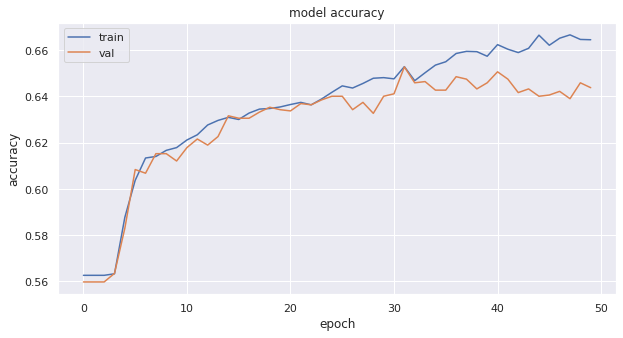

In [63]:
seed = 10
np.random.seed(seed)

model = create_model()
history = model.fit(X_NN_train, y_NN_train, validation_split = 0.2, epochs=50, batch_size= 512, verbose =0)
#callbacks=[es]

# plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [64]:
stop = timeit.default_timer()

print('Time: ', stop - start) 

Time:  5.6364646929999935


In [65]:
estimator = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=50, batch_size=512, validation_split = 0.2, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X_NN_train, y_NN_train, cv=kfold)
print(" Training Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


<ipython-input-65-4a24ad0f1585>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=50, batch_size=512, validation_split = 0.2, verbose=0)


 Training Accuracy: 64.67% (1.03%)


In [66]:
estimator = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=50, batch_size=512, validation_split = 0.2, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X_NN_test , y_NN_test , cv=kfold)
print(" Testing  Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

<ipython-input-66-becea31ff12a>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=50, batch_size=512, validation_split = 0.2, verbose=0)


 Testing  Accuracy: 62.89% (2.31%)


In [67]:
n = 0
acc_scores = []
while n < 10:
    print(n)
    model = create_model()
    history = model.fit(X_NN_train, y_NN_train, validation_split = 0.2, epochs=50, batch_size=512, verbose =0)
    loss_and_metrics = model.evaluate(X_NN_test, y_NN_test)
    acc_scores.append(loss_and_metrics[1])
    n +=1

0
99/99 [==============================] - 0s 2ms/step - loss: 0.6323 - accuracy: 0.6365
1
99/99 [==============================] - 0s 1ms/step - loss: 0.6019 - accuracy: 0.6721
2
99/99 [==============================] - 0s 1ms/step - loss: 0.6031 - accuracy: 0.6695
3
99/99 [==============================] - 0s 1ms/step - loss: 0.6091 - accuracy: 0.6622
4
99/99 [==============================] - 0s 1ms/step - loss: 0.6191 - accuracy: 0.6508
5
99/99 [==============================] - 0s 1ms/step - loss: 0.6116 - accuracy: 0.6556
6
99/99 [==============================] - 0s 2ms/step - loss: 0.5988 - accuracy: 0.6736
7
99/99 [==============================] - 0s 2ms/step - loss: 0.6223 - accuracy: 0.6438
8
99/99 [==============================] - 0s 1ms/step - loss: 0.5973 - accuracy: 0.6809
9
99/99 [==============================] - 0s 2ms/step - loss: 0.6200 - accuracy: 0.6508


In [68]:

acc_scores = pd.Series(acc_scores)
acc_scores.describe()


count    10.000000
mean      0.659594
std       0.014393
min       0.636537
25%       0.650809
50%       0.658896
75%       0.671424
max       0.680939
dtype: float64

Logistic Regression

In [69]:
df_LR = df_enco.copy()

In [70]:
df_LR.head()

,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,...,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,direction_same,Y,driving_distance
0,0,2,2,2,4,0,0,0,3,1,...,7,3,4,4,0,1,0,0,0,2
1,1,2,0,0,2,1,0,0,3,1,...,7,3,4,4,0,1,0,0,1,2
2,1,2,0,0,1,1,0,0,3,1,...,7,3,4,4,0,1,0,0,0,0
3,1,2,0,2,2,1,0,0,3,1,...,7,3,4,4,0,1,0,0,1,0
4,1,2,0,2,2,0,0,0,3,1,...,7,3,4,4,0,1,0,0,1,0


In [71]:
X = df_LR.drop('Y',axis=1)
y = df_LR['Y']

test_X = X.sample(frac = 0.25, random_state = None)
test_y = y[test_X.index]
train_X = X.drop(test_X.index)
train_y = y.drop(test_y.index)


In [72]:
from IPython.testing import test 
from dataclasses import dataclass
@dataclass
class LogisticRegression1:
    df_pro: int
    learningRate: float
    epsilon: float
    maxIteration: int
    #filePath: str
    removeIndex: bool
    index:int

    def __post_init__(self):
      self.train_X, self.test_X, self.train_y, self.test_y = self.readDataset()
    
    def readDataset(self):
      #df_pro= pd.read_csv(filePath)
      X = df_LR.drop('Y',axis=1)
      y = df_LR['Y']

      test_X = X.sample(frac = 0.25, random_state = None)
      test_y = y[test_X.index]
      train_X = X.drop(test_X.index)
      train_y = y.drop(test_y.index)

      return train_X, test_X, train_y, test_y
  

  
    def sigmoid(self, z):
      sig= 1/(1+ np.exp(-z))
      return sig

    def costFunction(self, X, y):
      sig= self.sigmoid(X.dot(self.w))

      cost= (y* np.log(sig)+(1-y)*np.log(1-sig)).sum()
      cost=-cost/X.shape[0]

      return cost

    def gradient(self,X,y):
      sig= self.sigmoid(X.dot(self.w))
      gradient= (sig - y).dot(X)
      return gradient

    def gradientDescent(self, X, y):
      errors=[]
      last_error= float('inf')

      for i in tqdm(range(self.maxIteration)):
        self.w=self.w- self.learningRate*self.gradient(X,y)

        current_error= self.costFunction(X,y)
        diff= last_error-current_error
        last_error=current_error
        errors.append(current_error)

        if np.abs(diff)< self.epsilon:
          print (" the model stopped learning")
          break
      return

    def predict( self, X):
      sig= self.sigmoid(X.dot(self.w))
      return np.around(sig)

    def evaluate(self, y, y_hat):
      y= (y==1)  
      y_hat=(y_hat==1)

      recall= (y & y_hat).sum()/ y.sum()
      precision= (y & y_hat).sum()/ y_hat.sum()

      f_score= 2*(precision* recall)/(precision +recall)
      return f_score, recall, precision

    def plot(self):
      plt.figure(figsize=(12, 8))
      ax = plt.axes(projection='3d')

      ax.scatter3D(self.X_train[:, 0], self.X_train[:, 1], 
                  self.sigmoid(self.X_train.dot(self.w)), 
                  c = self.y_train[:], cmap='viridis', s=100);

      ax.set_xlim3d(55, 80)
      ax.set_ylim3d(80, 240)
      plt.xlabel('$x_1$ feature', fontsize=15)
      plt.ylabel('$x_2$ feature', fontsize=15, )
      ax.set_zlabel('$P(Y = 1|x_1, x_2)$', fontsize=15, rotation = 0)
 
  
    def scatterPlt(self):

      x_min, x_max = 55,80
      y_min, y_max = 80, 240

      xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                          np.linspace(y_min, y_max, 250))
      grid = np.c_[xx.ravel(), yy.ravel()]
      probs = grid.dot(self.w).reshape(xx.shape)

      f, ax = plt.subplots(figsize=(14,12))


      ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)


      ax.scatter(self.X_train[:, 0], self.X_train[:, 1], 
                c=self.y_train[:], s=50,
                cmap="RdBu", vmin=-.2, vmax=1.2,
                edgecolor="white", linewidth=1)

      plt.xlabel('x1 feature')
      plt.ylabel('x2 feature')
      plt.show()
      

    def plot3D(self):
      x_min, x_max = 55, 80
      y_min, y_max = 80, 240
    
      xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                          np.linspace(y_min, y_max, 250))
    
      grid = np.c_[xx.ravel(), yy.ravel()]
      probs = grid.dot(self.w).reshape(xx.shape)
      fig = plt.figure(figsize=(14,12))
      ax = plt.axes(projection='3d')
      ax.contour3D(xx, yy, probs, 50, cmap='binary')

      ax.scatter3D(self.X_train[:, 0], self.X_train[:, 1], 
                c=self.y_train[:], s=50,
                cmap="RdBu", vmin=-.2, vmax=1.2,
                edgecolor="white", linewidth=1)

      ax.set_xlabel('x1')
      ax.set_ylabel('x2')
      ax.set_zlabel('probs')
      ax.set_title('3D contour')
      plt.show()

    def fit1(self):

    
      self.w= np.ones(self.train_X.shape[1], dtype= np.float64) * 0

      self.gradientDescent(self.train_X, self.train_y)
      print(self.w)

      y_train_hat= self.predict(self.train_X)
  
      f_score, recall, precision = self.evaluate(self.train_y, y_train_hat)

      print("The train F1 score of the model is {}".format(f_score))
      print("The train recall score of the model is {}".format(recall))
      print("The train precision score of the model is {}".format(precision))

In [73]:
lr= LogisticRegression1(df_LR, learningRate=0.3, epsilon=0.01, maxIteration=10000, removeIndex=False, index=[])
lr.fit1()

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-72-10517d41af3b>:55: RuntimeWarning: invalid value encountered in double_scalars
  diff= last_error-current_error
100%|██████████| 10000/10000 [01:27<00:00, 114.47it/s]

passanger               -4953.484109
weather                -10382.664195
temperature              -219.946387
time                     2784.415628
coupon                  -8750.722362
expiration              32076.968651
gender                  -8126.598920
age                       559.242997
maritalStatus           -1914.158801
has_children             4582.107126
education               -5313.465503
occupation              -3680.569525
income                  -1810.892393
Bar                     -1036.667411
CoffeeHouse              5923.471636
CarryAway                1051.525972
RestaurantLessThan20    -2496.482282
Restaurant20To50          468.749263
direction_same         -12729.024751
driving_distance        -2701.171747
dtype: float64
The train F1 score of the model is 0.05549079039403124
The train recall score of the model is 0.029102470041574957
The train precision score of the model is 0.595


In [74]:
print("train accuracy: {}".format(accuracy_score(train_y, lr.predict(train_X))))

train accuracy: 57.04


In [75]:
print("test accuracy: {}".format(accuracy_score(test_y, lr.predict(test_X))))

test accuracy: 57.99


In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
clf = LogisticRegression(random_state=0).fit(test_X, test_y)

In [78]:
print("train accuracy: {}".format(accuracy_score(train_y, clf.predict(train_X))))

train accuracy: 62.55
